<a href="https://colab.research.google.com/github/SSM11011/Predicting-User-Churn-for-an-E-commerce-Platform/blob/main/Predicting_User_Churn_for_an_E_commerce_Platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    return summary

In [3]:
df = pd.read_csv("/content/events.csv")
resumetable(df)

Dataset Shape: (885129, 9)


,Name,dtypes,Missing,Uniques,First Value,Second Value
0,event_time,object,0,845041,2020-09-24 11:57:06 UTC,2020-09-24 11:57:26 UTC
1,event_type,object,0,3,view,view
2,product_id,int64,0,53453,1996170,139905
3,category_id,int64,0,718,2144415922528452715,2144415926932472027
4,category_code,object,236219,107,electronics.telephone,computers.components.cooler
5,brand,object,212364,999,NaN,zalman
6,price,float64,0,12422,31.9,17.16
7,user_id,int64,0,407283,1515915625519388267,1515915625519380411
8,user_session,object,165,490398,LJuJVLEjPT,tdicluNnRY


In [4]:
def feature_engineer(data):
    # Convert event_time to datetime (create a copy to avoid SettingWithCopyWarning)
    data = data.copy()
    data['event_time'] = pd.to_datetime(data['event_time'], utc=True, errors='coerce')

    # Drop rows with missing user_session
    data = data.dropna(subset=['user_session'])

    # Fill missing values
    data.loc[:, 'brand'] = data['brand'].fillna('unknown')
    data.loc[:, 'category_code'] = data['category_code'].fillna('unknown')

    # Sort data by user_id and event_time
    data = data.sort_values(by=['user_id', 'event_time'])

    # Calculate RFM metrics
    rfm = data[data['event_type'] == 'purchase'].groupby('user_id').agg(
        recency=('event_time', lambda x: (data['event_time'].max() - x.max()).days),
        frequency=('event_time', 'count'),
        monetary=('price', 'sum')
    ).reset_index()

    # Time-based patterns and preferences
    data['hour'] = data['event_time'].dt.hour
    data['day_of_week'] = data['event_time'].dt.dayofweek

    temporal_features = data.groupby('user_id').agg(
        first_interaction=('event_time', 'min'),
        last_interaction=('event_time', 'max'),
        activity_days=('event_time', lambda x: x.dt.date.nunique()),
        inactivity_period=('event_time', lambda x: (x.max() - x.min()).days),
        customer_lifespan=('event_time', lambda x: (x.max() - x.min()).days)
    ).reset_index()

    temporal_features['days_since_last_interaction'] = (
        data['event_time'].max() - temporal_features['last_interaction']).dt.days

    time_preferences = data.groupby('user_id').agg(
        morning_shopper=('hour', lambda x: ((x >= 5) & (x < 12)).mean()),
        afternoon_shopper=('hour', lambda x: ((x >= 12) & (x < 17)).mean()),
        evening_shopper=('hour', lambda x: ((x >= 17) & (x < 22)).mean()),
        night_shopper=('hour', lambda x: ((x >= 22) | (x < 5)).mean()),
        weekday_shopper=('day_of_week', lambda x: (x < 5).mean()),
        weekend_shopper=('day_of_week', lambda x: (x >= 5).mean())
    ).reset_index()

    # Purchase acceleration
    purchase_times = data[data['event_type'] == 'purchase'].groupby('user_id')['event_time'].agg(list).reset_index()
    purchase_times['avg_time_between_purchases'] = purchase_times['event_time'].apply(
        lambda x: np.mean([(x[i+1] - x[i]).total_seconds()/86400 for i in range(len(x)-1)]) if len(x) > 1 else np.nan
    )
    purchase_times = purchase_times[['user_id', 'avg_time_between_purchases']]

    # Session-based metrics
    session_metrics = data.groupby(['user_id', 'user_session']).agg(
        session_start=('event_time', 'min'),
        session_end=('event_time', 'max'),
        session_events=('event_time', 'count'),
        session_value=('price', 'sum')
    ).reset_index()

    session_metrics['session_duration'] = (session_metrics['session_end'] - session_metrics['session_start']).dt.total_seconds()
    session_metrics['value_density'] = session_metrics['session_value'] / (session_metrics['session_duration'] / 60)  # value per minute

    user_session_metrics = session_metrics.groupby('user_id').agg(
        session_count=('user_session', 'nunique'),
        avg_session_duration=('session_duration', 'mean'),
        session_variance=('session_duration', 'var'),
        total_events=('session_events', 'sum'),
        bounce_rate=('session_events', lambda x: (x == 1).sum() / len(x)),
        avg_value_density=('value_density', 'mean')
    ).reset_index()

    # Product/brand preferences and loyalty
    product_preferences = data[data['event_type'] == 'view'].groupby('user_id').agg(
        most_viewed_brand=('brand', lambda x: x.mode()[0] if not x.mode().empty else 'unknown'),
        most_viewed_category=('category_code', lambda x: x.mode()[0] if not x.mode().empty else 'unknown')
    ).reset_index()

    purchase_preferences = data[data['event_type'] == 'purchase'].groupby('user_id').agg(
        top_purchased_category=('category_code', lambda x: x.mode()[0] if not x.mode().empty else 'unknown')
    ).reset_index()

    # Brand loyalty calculation
    total_interactions = data.groupby('user_id')['brand'].count().reset_index(name='total_interactions')
    brand_interactions = data.groupby(['user_id', 'brand']).size().reset_index(name='brand_interactions')
    brand_interactions = brand_interactions.merge(total_interactions, on='user_id')
    brand_interactions['brand_interaction_ratio'] = brand_interactions['brand_interactions'] / brand_interactions['total_interactions']
    brand_loyalty = brand_interactions.groupby('user_id')['brand_interaction_ratio'].max().reset_index(name='brand_loyalty_score')

    # Behavioral patterns
    behavior_patterns = data.groupby('user_id').agg(
        views=('event_type', lambda x: (x == 'view').sum()),
        carts=('event_type', lambda x: (x == 'cart').sum()),
        purchases=('event_type', lambda x: (x == 'purchase').sum())
    ).reset_index()

    behavior_patterns['view_to_cart_ratio'] = behavior_patterns['carts'] / behavior_patterns['views']
    behavior_patterns['cart_to_purchase_ratio'] = behavior_patterns['purchases'] / behavior_patterns['carts']
    behavior_patterns['view_to_cart_ratio'] = behavior_patterns['view_to_cart_ratio'].fillna(0)
    behavior_patterns['cart_to_purchase_ratio'] = behavior_patterns['cart_to_purchase_ratio'].fillna(0)

    # Browse-to-Purchase behavior
    browse_purchase = data.groupby(['user_id', 'user_session']).agg(
        views_before_purchase=('event_type', lambda x: (x == 'view').sum()),
        has_purchase=('event_type', lambda x: (x == 'purchase').any())
    ).reset_index()

    browse_metrics = browse_purchase.groupby('user_id').agg(
        avg_views_before_purchase=('views_before_purchase', 'mean'),
        session_conversion_rate=('has_purchase', 'mean')
    ).reset_index()

    # Price sensitivity and patterns
    price_sensitivity = data.groupby('user_id').agg(
        price_variance=('price', 'std'),
        price_range=('price', lambda x: x.max() - x.min()),
        avg_price_viewed=('price', lambda x: x[data['event_type'] == 'view'].mean()),
        avg_price_purchased=('price', lambda x: x[data['event_type'] == 'purchase'].mean()),
        high_value_interactions=('price', lambda x: (x > x.mean()).sum()),
        low_value_interactions=('price', lambda x: (x < x.mean()).sum())
    ).reset_index()

    price_sensitivity['price_sensitivity_score'] = (
        price_sensitivity['avg_price_purchased'] / price_sensitivity['avg_price_viewed']
    ).fillna(0)

    # Cart abandonment metrics
    cart_events = data[data['event_type'].isin(['cart', 'purchase'])].copy()
    cart_events['event_order'] = cart_events.groupby('user_id').cumcount()
    cart_abandonment = cart_events.groupby('user_id').agg(
        cart_abandonment_rate=('event_type', lambda x: 1 - (x == 'purchase').sum() / max(1, (x == 'cart').sum()))
    ).reset_index()

    # Product interaction patterns
    product_patterns = data.groupby('user_id').agg(
        distinct_products=('product_id', 'nunique'),
        distinct_brands=('brand', 'nunique'),
        distinct_categories=('category_code', 'nunique'),
        category_diversity=('category_id', 'nunique'),
        category_exploration_index=('category_code', lambda x: x.nunique() / x.count()),
        repeat_view_rate=('product_id', lambda x: 1 - x[data['event_type'] == 'view'].nunique() / max(1, (x == 'view').sum()))
    ).reset_index()

    # Calculate interaction_per_day
    temporal_features['interaction_per_day'] = product_patterns['distinct_products'] / temporal_features['activity_days']

    # Merge all features
    user_features = rfm
    user_features = user_features.merge(temporal_features, on='user_id', how='left')
    user_features = user_features.merge(time_preferences, on='user_id', how='left')
    user_features = user_features.merge(purchase_times, on='user_id', how='left')
    user_features = user_features.merge(user_session_metrics, on='user_id', how='left')
    user_features = user_features.merge(product_preferences, on='user_id', how='left')
    user_features = user_features.merge(purchase_preferences, on='user_id', how='left')
    user_features = user_features.merge(brand_loyalty, on='user_id', how='left')
    user_features = user_features.merge(behavior_patterns, on='user_id', how='left')
    user_features = user_features.merge(browse_metrics, on='user_id', how='left')
    user_features = user_features.merge(price_sensitivity, on='user_id', how='left')
    user_features = user_features.merge(cart_abandonment, on='user_id', how='left')
    user_features = user_features.merge(product_patterns, on='user_id', how='left')

    # Fill NaN values
    user_features = user_features.fillna(0)

    return user_features

In [5]:
# Calculate temporal features
temporal_features = df.groupby('user_id').agg(
    first_interaction=('event_time', 'min'),
    last_interaction=('event_time', 'max')
).reset_index()

# Convert 'first_interaction' and 'last_interaction' to datetime objects
temporal_features['first_interaction'] = pd.to_datetime(temporal_features['first_interaction'], utc=True, errors='coerce')
temporal_features['last_interaction'] = pd.to_datetime(temporal_features['last_interaction'], utc=True, errors='coerce')

# Inactivity period: Days between the first and last interaction
temporal_features['customer_lifespan'] = (
    temporal_features['last_interaction'] - temporal_features['first_interaction']
).dt.days

# Days since last interaction: Days since the last recorded event
# Convert 'event_time' column to datetime first:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True, errors='coerce')
temporal_features['days_since_last_interaction'] = (
    df['event_time'].max() - temporal_features['last_interaction']
).dt.days

# Display the resulting features
temporal_features.describe()

,user_id,customer_lifespan,days_since_last_interaction
count,4.072830e+05,407283.000000,407283.000000
mean,1.515916e+18,1.225239,78.484847
std,3.358013e+07,7.983615,45.328033
min,1.515916e+18,0.000000,0.000000
25%,1.515916e+18,0.000000,38.000000
50%,1.515916e+18,0.000000,81.000000
75%,1.515916e+18,0.000000,117.000000
max,1.515916e+18,156.000000,157.000000


In [6]:
temporal_features['churn'] = (
    (temporal_features['days_since_last_interaction'] > 30) &
    (temporal_features['days_since_last_interaction'] > temporal_features['customer_lifespan'])
).astype(int)

In [7]:
temporal_features['churn'].value_counts()

,count
churn,
1,324185
0,83098


In [8]:
original_df = df
original_df['event_time'] = pd.to_datetime(original_df['event_time'], utc=True, errors='coerce')
feature_engineered_df = feature_engineer(df[:10000])
resumetable(feature_engineered_df)

Dataset Shape: (231, 49)


,Name,dtypes,Missing,Uniques,First Value,Second Value
0,user_id,int64,0,231,1515915625354561351,1515915625357781243
1,recency,int64,0,3,1,0
2,frequency,int64,0,7,2,1
3,monetary,float64,0,201,103.36,75.67
4,first_interaction,"datetime64[ns, UTC]",0,231,2020-09-25 08:21:08+00:00,2020-09-26 11:55:29+00:00
5,last_interaction,"datetime64[ns, UTC]",0,231,2020-09-25 08:43:04+00:00,2020-09-26 11:56:57+00:00
6,activity_days,int64,0,3,1,1
7,inactivity_period,int64,0,3,0,0
8,customer_lifespan,int64,0,3,0,0
9,days_since_last_interaction,int64,0,3,1,0


In [ ]:
# Calculate propensity to purchase
purchase_propensity = df.groupby('user_id').agg(
    total_sessions=('user_session', 'nunique'),
    purchase_sessions=('user_session', lambda x: df[df['event_type'] == 'purchase']['user_session'].nunique())
).reset_index()

purchase_propensity['propensity_to_purchase'] = (
    purchase_propensity['purchase_sessions'] / purchase_propensity['total_sessions']
)

In [10]:
feature_engineered_df['churn'] = (feature_engineered_df['days_since_last_interaction'] > 1).astype(int)

In [11]:
feature_engineered_df['churn'].value_counts()

,count
churn,
0,181
1,50


In [16]:
!pip install catboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor , CatBoostClassifier

In [17]:
target_col = 'churn'
X = feature_engineered_df.drop(columns=[target_col])
y = feature_engineered_df[target_col]

# Convert datetime features to numerical representations
# Ensure all datetime columns are properly converted
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
for col in datetime_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64') // 10**9  # Convert to Unix timestamp (seconds)

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Parameter grid for hyperparameter optimization
param_grid = {
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 25, 30, 40]
}

# Initialize the model with GPU support and silent mode
cat_boost_model = CatBoostRegressor(task_type='CPU', silent=True)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    estimator=cat_boost_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',
    verbose=1,
    error_score='raise'  # Debug errors by raising them
)

# Perform grid search
grid_search.fit(X, y, cat_features=categorical_cols)

# Retrieve the best parameters and best model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
optimized_model = CatBoostRegressor(
    **best_params,
    eval_metric='R2',
    task_type='CPU',
    verbose=50
)

optimized_model.fit(
    X, y,
    cat_features=categorical_cols,
    plot=True
)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'depth': 3, 'learning_rate': 0.1, 'n_estimators': 40}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1639124	total: 824us	remaining: 32.1ms
39:	learn: 0.9971029	total: 41.1ms	remaining: 0us


In [18]:
# Evaluate the model on the training set
y_pred_train = optimized_model.predict(X)
train_score = r2_score(y, y_pred_train)
print("Train R2 Score:", train_score)

Train R2 Score: 0.997102911997975


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'depth': 3, 'learning_rate': 0.01, 'n_estimators': 20}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 4.27ms	remaining: 81.1ms
19:	total: 31.5ms	remaining: 0us
Train ROC AUC Score: 1.0
Train F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00        50

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



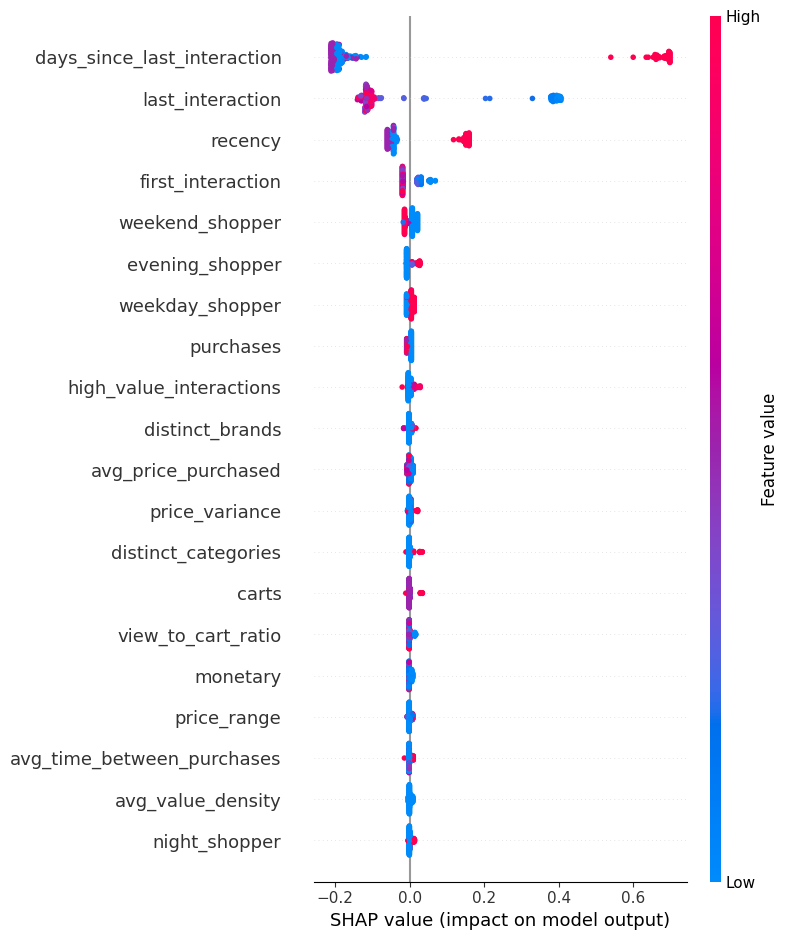

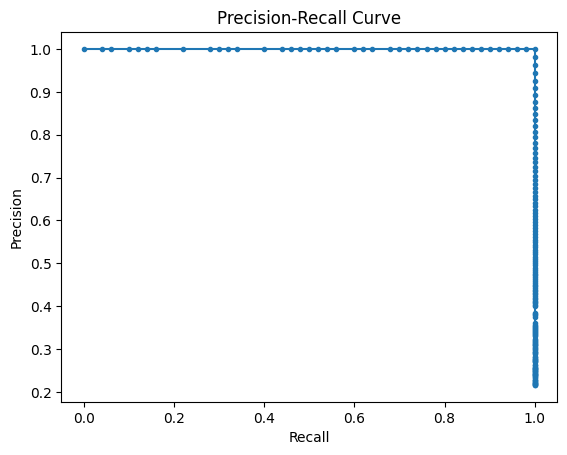

In [19]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, classification_report
import shap
import matplotlib.pyplot as plt

# Assuming `feature_engineered_df` has been properly loaded and preprocessed
target_col = 'churn'
X = feature_engineered_df.drop(columns=[target_col])
y = feature_engineered_df[target_col]

# Convert datetime features to numerical representations
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
for col in datetime_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64') // 10**9  # Convert to Unix timestamp (seconds)

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Parameter grid for hyperparameter optimization
param_grid = {
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 25, 30, 40]
}

# Initialize the model with GPU support and silent mode
cat_boost_model = CatBoostClassifier(task_type='CPU', silent=True)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    estimator=cat_boost_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='roc_auc',
    verbose=1,
    error_score='raise'  # Debug errors by raising them
)

# Perform grid search
grid_search.fit(X, y, cat_features=categorical_cols)

# Retrieve the best parameters and best model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
optimized_model = CatBoostClassifier(
    **best_params,
    eval_metric='AUC',
    task_type='CPU',
    verbose=50
)

optimized_model.fit(
    X, y,
    cat_features=categorical_cols,
    plot=True
)

# Evaluate the model on the training set
y_pred_train = optimized_model.predict(X)
y_pred_proba_train = optimized_model.predict_proba(X)[:, 1]

# Performance metrics
roc_auc = roc_auc_score(y, y_pred_proba_train)
f1 = f1_score(y, y_pred_train)
print("Train ROC AUC Score:", roc_auc)
print("Train F1 Score:", f1)

# Classification report
print("Classification Report:")
print(classification_report(y, y_pred_train))

# Feature importance using SHAP
explainer = shap.TreeExplainer(optimized_model)
shap_values = explainer.shap_values(X)

# Plot feature importance
shap.summary_plot(shap_values, X)

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y, y_pred_proba_train)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [20]:
# Select only numerical columns
numerical_cols = X.select_dtypes(include=['number']).columns

# Calculate the correlation matrix between numerical columns
correlation_matrix = X[numerical_cols].corr()

# Calculate the correlation of each numerical feature with the target column
target_corr = X[numerical_cols].corrwith(y)

# Convert to DataFrame for easier visualization
target_corr_df = target_corr.to_frame(name='Correlation with Target')

# Sort the correlations in descending order
target_corr_sorted = target_corr_df.sort_values(by='Correlation with Target', ascending=False)
target_corr_sorted

,Correlation with Target
days_since_last_interaction,0.808592
recency,0.765291
weekday_shopper,0.372846
afternoon_shopper,0.299201
evening_shopper,0.193368
session_conversion_rate,0.161965
repeat_view_rate,0.120012
category_exploration_index,0.088245
brand_loyalty_score,0.080007
user_id,0.078440


In [21]:
def feature_engineer(data):
    # Convert event_time to datetime
    data = data.copy()
    data['event_time'] = pd.to_datetime(data['event_time'], utc=True, errors='coerce')
    data = data.dropna(subset=['event_time'])

    # Ensure all user_id values are captured
    all_users = pd.DataFrame({'user_id': data['user_id'].unique()})

    # Sort data by user_id and event_time
    data = data.sort_values(by=['user_id', 'event_time'])

    # Calculate RFM metrics
    rfm = data[data['event_type'] == 'purchase'].groupby('user_id').agg(
        recency=('event_time', lambda x: (data['event_time'].max() - x.max()).days),
        frequency=('event_time', 'count'),
        monetary=('price', 'sum')
    ).reset_index()
    rfm = all_users.merge(rfm, on='user_id', how='left')

    # Time-based patterns and preferences
    data['hour'] = data['event_time'].dt.hour
    data['day_of_week'] = data['event_time'].dt.dayofweek

    temporal_features = data.groupby('user_id').agg(
        first_interaction=('event_time', 'min'),
        last_interaction=('event_time', 'max'),
        activity_days=('event_time', lambda x: x.dt.date.nunique()),
        inactivity_period=('event_time', lambda x: (x.max() - x.min()).days),
        customer_lifespan=('event_time', lambda x: (x.max() - x.min()).days)
    ).reset_index()

    temporal_features['days_since_last_interaction'] = (
        data['event_time'].max() - temporal_features['last_interaction']).dt.days

    time_preferences = data.groupby('user_id').agg(
        morning_shopper=('hour', lambda x: ((x >= 5) & (x < 12)).mean()),
        afternoon_shopper=('hour', lambda x: ((x >= 12) & (x < 17)).mean()),
        evening_shopper=('hour', lambda x: ((x >= 17) & (x < 22)).mean()),
        night_shopper=('hour', lambda x: ((x >= 22) | (x < 5)).mean()),
        weekday_shopper=('day_of_week', lambda x: (x < 5).mean()),
        weekend_shopper=('day_of_week', lambda x: (x >= 5).mean())
    ).reset_index()

    # Merge all features
    user_features = all_users
    user_features = user_features.merge(rfm, on='user_id', how='left')
    user_features = user_features.merge(temporal_features, on='user_id', how='left')
    user_features = user_features.merge(time_preferences, on='user_id', how='left')

    # Fill NaN values
    user_features = user_features.fillna(0)

    return user_features

In [22]:
df.user_id.unique().shape

(407283,)

In [23]:
original_df = df
original_df['event_time'] = pd.to_datetime(original_df['event_time'], utc=True, errors='coerce')
feature_engineered_df = feature_engineer(df[:10])
resumetable(feature_engineered_df)

Dataset Shape: (10, 16)


,Name,dtypes,Missing,Uniques,First Value,Second Value
0,user_id,int64,0,10,1515915625519388267,1515915625519380411
1,recency,int64,0,1,0,0
2,frequency,float64,0,1,0.0,0.0
3,monetary,float64,0,1,0.0,0.0
4,first_interaction,"datetime64[ns, UTC]",0,10,2020-09-24 11:57:06+00:00,2020-09-24 11:57:26+00:00
5,last_interaction,"datetime64[ns, UTC]",0,10,2020-09-24 11:57:06+00:00,2020-09-24 11:57:26+00:00
6,activity_days,int64,0,1,1,1
7,inactivity_period,int64,0,1,0,0
8,customer_lifespan,int64,0,1,0,0
9,days_since_last_interaction,int64,0,1,0,0
